In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from scipy.stats import zscore

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

le = LabelEncoder()
adata_log_CR_NR.obs['Response_Encoded'] = le.fit_transform(adata_log_CR_NR.obs['response'])

genes = [
    "ITGB2", "CD7", "CTSW", "CD81", "AHNAK", "PRDX1", "ITM2A",
    "PLP2", "HMGB1", "CSGALNACT2", "ENO1", "ISG20", "FABP5",
    "FCER1G", "SRGN", "KANSL1", "IFITM2", "ZFP36L2", "IFITM3", "HLA-DRB5"
]

evaluation_results = []
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for gene in genes:
    model_data = []
    patients = adata_log_CR_NR.obs['barcode'].unique()
    
    # Calculate the proportion from the log-transformed data and gene count from the combat-corrected data
    for patient in patients:
        patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
        patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]

        gene_expr_log = patient_data_log[:, gene].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene].X > 0
        proportion = np.sum(gene_expr_log) / patient_data_log.shape[0]
        gene_count = np.mean(patient_data_combat[:, gene].X)

        model_data.append({
            'Patient': patient,
            'Response_Encoded': patient_data_log.obs['Response_Encoded'].values[0], 
            'Proportion_Positive': proportion,
            f'{gene}_Count': gene_count
        })

    model_df = pd.DataFrame(model_data)
    model_df[f'{gene}_Count'] = model_df[f'{gene}_Count'].astype(float)

    X = model_df[['Proportion_Positive', f'{gene}_Count']]
    y = model_df['Response_Encoded']

    # Perform 5-fold cross-validation
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    fold_auc_roc = []
    fold_auc_pr = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_model = xgb.XGBClassifier(random_state = 42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probability for the positive class


        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc_roc = roc_auc_score(y_test, y_prob)
        auc_pr = average_precision_score(y_test, y_prob)

        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1s.append(f1)
        fold_auc_roc.append(auc_roc)
        fold_auc_pr.append(auc_pr)

    # Store the average metrics across the 5 folds
    evaluation_results.append({
        'Gene': gene,
        'Accuracy': np.mean(fold_accuracies),
        'Precision': np.mean(fold_precisions),
        'Recall': np.mean(fold_recalls),
        'F1_Score': np.mean(fold_f1s),
        'AUC_ROC': np.mean(fold_auc_roc),
        'AUC_PR': np.mean(fold_auc_pr)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.to_csv('/home/emma/result/CART/CD8_Figure3_1_gene_xgboost.csv', index=False)
strong_predictors = evaluation_df[
    (evaluation_df['AUC_PR'] > 0.8) &    # Primary criterion
    (evaluation_df['AUC_ROC'] > 0.8)      # Secondary criterion
]

strong_predictors_ranked = strong_predictors.sort_values('AUC_PR', ascending=False)

# Display the genes and their performance
print("\nGenes meeting criteria (AUC-PR > 0.8 AND AUC-ROC > 0.8):")
print("\nResults:")
print(strong_predictors_ranked[['Gene', 'AUC_PR', 'AUC_ROC']])

strong_predictors_ranked.to_csv('/home/emma/result/CART/CD8_Figure3_1_gene_xgboost_strong_predictors.csv', index=False)

print("XGBoost evaluation with 5-fold cross-validation complete. Results exported to '/home/emma/result/CART/CD8_Figure3_1_gene_xgboost_strong_predictors.csv'.")

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emma/miniconda3/envs/s


Genes meeting criteria (AUC-PR > 0.8 AND AUC-ROC > 0.8):

Results:
     Gene    AUC_PR   AUC_ROC
3    CD81  0.950000  0.900000
12  FABP5  0.933333  0.925000
1     CD7  0.816667  0.808333
XGBoost evaluation with 5-fold cross-validation complete. Results exported to '/home/emma/result/CART/CD8_Figure3_1_gene_xgboost_strong_predictors.csv'.


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

le = LabelEncoder()
adata_log_CR_NR.obs['Response_Encoded'] = le.fit_transform(adata_log_CR_NR.obs['response'])

genes = [
    "CD81", "FABP5", "CD7"
]

results = []

for gene in genes:
    # Prepare a list to store the data for the PERMANOVA analysis
    model_data = []
    patients = adata_log_CR_NR.obs['barcode'].unique()
    
    # Calculate the proportion from the log-transformed data and gene count from the combat-corrected data
    for patient in patients:
        patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
        patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]

        gene_expr_log = patient_data_log[:, gene].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene].X > 0
        proportion = np.sum(gene_expr_log) / patient_data_log.shape[0]
        gene_count = np.mean(patient_data_combat[:, gene].X)

        model_data.append({
            'Patient': patient,
            'Response_Encoded': patient_data_log.obs['Response_Encoded'].values[0], 
            'Proportion_Positive': proportion,
            f'{gene}_Count': gene_count
        })

    model_df = pd.DataFrame(model_data)
    model_df[f'{gene}_Count'] = model_df[f'{gene}_Count'].astype(float)

    # Normalize the variables using Z-scores
    model_df['Proportion_Positive_Z'] = zscore(model_df['Proportion_Positive'])
    model_df[f'{gene}_Count_Z'] = zscore(model_df[f'{gene}_Count'])

    # Calculate the distance matrix for the two normalized variables
    dist_matrix = squareform(pdist(model_df[['Proportion_Positive_Z', f'{gene}_Count_Z']], metric='euclidean'))

    # Prepare unique IDs for each sample
    ids = model_df.index.to_list()

    # Convert the distance matrix into a skbio DistanceMatrix object
    dist_matrix = DistanceMatrix(dist_matrix, ids=ids)

    # Perform PERMANOVA for CR vs NR
    result_CR_NR = permanova(dist_matrix, model_df['Response_Encoded'], permutations=999)

    p_val_CR_NR = result_CR_NR['p-value']
    pseudo_F_CR_NR = result_CR_NR['test statistic']

    if p_val_CR_NR < 0.05:
        results.append({
            'Gene': f'{gene}',
            'Pseudo-F CR vs NR': pseudo_F_CR_NR,
            'P-value CR vs NR': p_val_CR_NR
        })

results_df = pd.DataFrame(results)
ranked_genes = results_df.sort_values(by='P-value CR vs NR')
# Display the genes and their performance
print("\nGenes meeting criteria P-value CR vs NR < 0.05:")
print("\nResults:")
print(ranked_genes[['Gene', 'Pseudo-F CR vs NR', 'P-value CR vs NR']])

ranked_genes.to_excel('/home/emma/result/CART/CD8_Figure3_1_gene_permanova_results_CR_NR_new.xlsx', index=False)

print("Analysis complete. Results exported to '/home/emma/result/CART/CD8_Figure3_1_gene_permanova_results_CR_NR_new.xlsx'.")


Genes meeting criteria P-value CR vs NR < 0.05:

Results:
   Gene  Pseudo-F CR vs NR  P-value CR vs NR
0  CD81           5.555512             0.013
Analysis complete. Results exported to '/home/emma/result/CART/CD8_Figure3_1_gene_permanova_results_CR_NR_new.xlsx'.


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import itertools
from scipy.stats import zscore

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

le = LabelEncoder()
adata_log_CR_NR.obs['Response_Encoded'] = le.fit_transform(adata_log_CR_NR.obs['response'])

genes = [
    "ITGB2", "CD7", "CTSW", "CD81", "AHNAK", "PRDX1", "ITM2A",
    "PLP2", "HMGB1", "CSGALNACT2", "ENO1", "ISG20", "FABP5",
    "FCER1G", "SRGN", "KANSL1", "IFITM2", "ZFP36L2", "IFITM3", "HLA-DRB5"
]

evaluation_results = []

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

gene_pairs = itertools.combinations(genes, 2)
for gene1, gene2 in gene_pairs:
    model_data = []
    patients = adata_log_CR_NR.obs['barcode'].unique()
    for patient in patients:
        patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
        patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]

        gene1_expr_log = patient_data_log[:, gene1].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene1].X > 0
        gene2_expr_log = patient_data_log[:, gene2].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene2].X > 0
        both_genes_expr = np.logical_and(gene1_expr_log, gene2_expr_log)
        proportion = np.sum(both_genes_expr) / patient_data_log.shape[0]
        gene1_count_combat = np.mean(patient_data_combat[:, gene1].X)
        gene2_count_combat = np.mean(patient_data_combat[:, gene2].X)

        model_data.append({
            'Patient': patient,
            'Response_Encoded': patient_data_log.obs['Response_Encoded'].values[0],
            'Proportion_Positive': proportion,
            f'{gene1}_Count': gene1_count_combat,
            f'{gene2}_Count': gene2_count_combat
        })
      
    model_df = pd.DataFrame(model_data)
    model_df[f'{gene1}_Count'] = model_df[f'{gene1}_Count'].astype(float)
    model_df[f'{gene2}_Count'] = model_df[f'{gene2}_Count'].astype(float)

    X = model_df[['Proportion_Positive', f'{gene1}_Count', f'{gene2}_Count']]
    y = model_df['Response_Encoded']

    # Perform 5-fold cross-validation
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    fold_auc_roc = []
    fold_auc_pr = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_model = xgb.XGBClassifier(random_state = 42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc_roc = roc_auc_score(y_test, y_prob)
        auc_pr = average_precision_score(y_test, y_prob)

        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1s.append(f1)
        fold_auc_roc.append(auc_roc)
        fold_auc_pr.append(auc_pr)

    # Store the average metrics across the 5 folds
    evaluation_results.append({
        'Gene_Pair': f'{gene1} & {gene2}',
        'Accuracy': np.mean(fold_accuracies),
        'Precision': np.mean(fold_precisions),
        'Recall': np.mean(fold_recalls),
        'F1_Score': np.mean(fold_f1s),
        'AUC_ROC': np.mean(fold_auc_roc),
        'AUC_PR': np.mean(fold_auc_pr)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.to_csv('/home/emma/result/CART/CD8_Figure3_2_genes_xgboost.csv', index=False)
strong_predictors = evaluation_df[
    (evaluation_df['AUC_PR'] > 0.8) &    # Primary criterion
    (evaluation_df['AUC_ROC'] > 0.8)      # Secondary criterion
]

strong_predictors_ranked = strong_predictors.sort_values('AUC_PR', ascending=False)

# Display the genes and their performance
print("\nGenes meeting criteria (AUC-PR > 0.8 AND AUC-ROC > 0.8):")
print("\nResults:")
print(strong_predictors_ranked[['Gene_Pair', 'AUC_PR', 'AUC_ROC']])

strong_predictors_ranked.to_csv('/home/emma/result/CART/CD8_Figure3_2_gene_xgboost_strong_predictors.csv', index=False)

print("XGBoost evaluation with 5-fold cross-validation complete. Results exported to '/home/emma/result/CART/CD8_Figure3_2_gene_xgboost_strong_predictors.csv'.")

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emma/miniconda3/envs/s


Genes meeting criteria (AUC-PR > 0.8 AND AUC-ROC > 0.8):

Results:
               Gene_Pair    AUC_PR   AUC_ROC
146         ENO1 & FABP5  0.966667  0.975000
29           CD7 & FABP5  0.966667  0.975000
58          CD81 & HMGB1  0.966667  0.950000
127        HMGB1 & FABP5  0.950000  0.900000
129         HMGB1 & SRGN  0.933333  0.900000
2           ITGB2 & CD81  0.916667  0.850000
162       FABP5 & FCER1G  0.916667  0.875000
33          CD7 & IFITM2  0.916667  0.850000
62          CD81 & FABP5  0.900000  0.875000
91         PRDX1 & FABP5  0.900000  0.825000
137   CSGALNACT2 & FABP5  0.883333  0.825000
163         FABP5 & SRGN  0.883333  0.850000
26      CD7 & CSGALNACT2  0.866667  0.883333
138  CSGALNACT2 & FCER1G  0.866667  0.866667
11         ITGB2 & FABP5  0.850000  0.825000
5          ITGB2 & ITM2A  0.850000  0.825000
25           CD7 & HMGB1  0.833333  0.833333
104        ITM2A & FABP5  0.816667  0.816667
60           CD81 & ENO1  0.816667  0.833333
166      FABP5 & ZFP36L2  0.8166

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import itertools
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.stats import zscore

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

le = LabelEncoder()
adata_log_CR_NR.obs['Response_Encoded'] = le.fit_transform(adata_log_CR_NR.obs['response'])

gene_pairs = [
    ("ENO1", "FABP5"),
    ("CD7", "FABP5"),
    ("CD81", "HMGB1"),
    ("HMGB1", "FABP5"),
    ("HMGB1", "SRGN"),
    ("ITGB2", "CD81"),
    ("FABP5", "FCER1G"),
    ("CD7", "IFITM2"),
    ("CD81", "FABP5"),
    ("PRDX1", "FABP5"),
    ("CSGALNACT2", "FABP5"),
    ("FABP5", "SRGN"),
    ("CD7", "CSGALNACT2"),
    ("CSGALNACT2", "FCER1G"),
    ("ITGB2", "FABP5"),
    ("ITGB2", "ITM2A"),
    ("CD7", "HMGB1"),
    ("ITM2A", "FABP5"),
    ("CD81", "ENO1"),
    ("FABP5", "ZFP36L2")
]

results = []
for gene1, gene2 in gene_pairs:
    model_data = []
    patients = adata_log_CR_NR.obs['barcode'].unique()
    for patient in patients:
        patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
        patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]

        gene1_expr_log = patient_data_log[:, gene1].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene1].X > 0
        gene2_expr_log = patient_data_log[:, gene2].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene2].X > 0
        both_genes_expr = np.logical_and(gene1_expr_log, gene2_expr_log)
        proportion = np.sum(both_genes_expr) / patient_data_log.shape[0]
        gene1_count_combat = np.mean(patient_data_combat[:, gene1].X)
        gene2_count_combat = np.mean(patient_data_combat[:, gene2].X)

        # Append the data for PERMANOVA analysis
        model_data.append({
            'Patient': patient,
            'Response_Encoded': patient_data_log.obs['Response_Encoded'].values[0],
            'Proportion_Positive': proportion,
            f'{gene1}_Count': gene1_count_combat,
            f'{gene2}_Count': gene2_count_combat
        })
      
    model_df = pd.DataFrame(model_data)
    model_df[f'{gene1}_Count'] = model_df[f'{gene1}_Count'].astype(float)
    model_df[f'{gene2}_Count'] = model_df[f'{gene2}_Count'].astype(float)
    # Normalize the variables using Z-scores
    model_df['Proportion_Positive_Z'] = zscore(model_df['Proportion_Positive'])
    model_df[f'{gene1}_Count_Z'] = zscore(model_df[f'{gene1}_Count'])
    model_df[f'{gene2}_Count_Z'] = zscore(model_df[f'{gene2}_Count'])


    dist_matrix = squareform(pdist(model_df[['Proportion_Positive_Z', f'{gene1}_Count_Z', f'{gene2}_Count_Z']], metric='euclidean'))
    ids = model_df.index.to_list()
    dist_matrix = DistanceMatrix(dist_matrix, ids=ids)
    result_CR_NR = permanova(dist_matrix, model_df['Response_Encoded'], permutations=999)

    p_val_CR_NR = result_CR_NR['p-value']
    pseudo_F_CR_NR = result_CR_NR['test statistic']

    if p_val_CR_NR < 0.05:
        results.append({
            'Gene_Pair': f'{gene1} & {gene2}',
            'Pseudo-F CR vs NR': pseudo_F_CR_NR,
            'P-value CR vs NR': p_val_CR_NR
        })

results_df = pd.DataFrame(results)
ranked_pairs = results_df.sort_values(by='P-value CR vs NR')
# Display the genes and their performance
print("\nGenes meeting criteria P-value CR vs NR < 0.05:")
print("\nResults:")
print(ranked_pairs[['Gene_Pair', 'Pseudo-F CR vs NR', 'P-value CR vs NR']])

ranked_pairs.to_excel('/home/emma/result/CART/CD8_Figure3_2_genes_permanova_results_CR_NR_new.xlsx', index=False)

print("Analysis complete. Results exported to '/home/emma/result/CART/CD8_Figure3_2_genes_permanova_results_CR_NR_new.xlsx'.")


Genes meeting criteria P-value CR vs NR < 0.05:

Results:
      Gene_Pair  Pseudo-F CR vs NR  P-value CR vs NR
2  CD81 & FABP5           4.566138             0.008
3   CD81 & ENO1           4.289948             0.012
0  CD81 & HMGB1           4.238152             0.014
1  ITGB2 & CD81           3.481461             0.034
Analysis complete. Results exported to '/home/emma/result/CART/CD8_Figure3_2_genes_permanova_results_CR_NR_new.xlsx'.


Gene: CD81

Total number of tests being corrected for: 2

Results for CD81:
Proportion:
  Raw p-value: 0.1024
  FDR-corrected p-value: 0.1024
  Bonferroni-corrected p-value: 0.2048
CD81 Counts:
  Raw p-value: 0.0304
  FDR-corrected p-value: 0.0607
  Bonferroni-corrected p-value: 0.0607


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


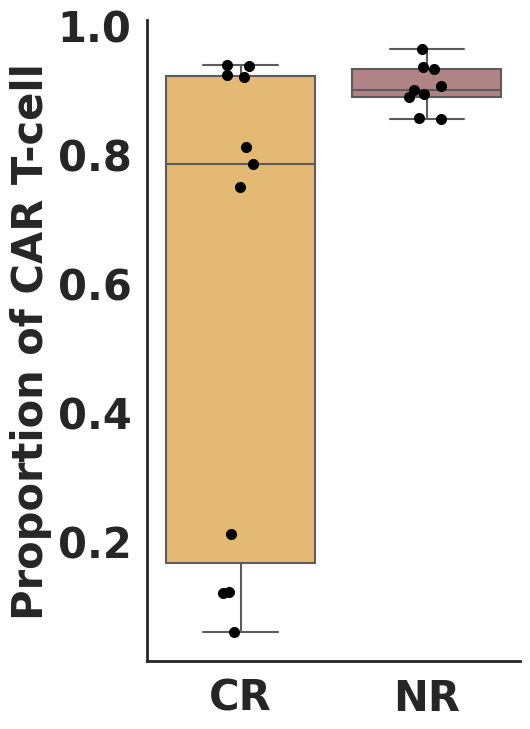

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


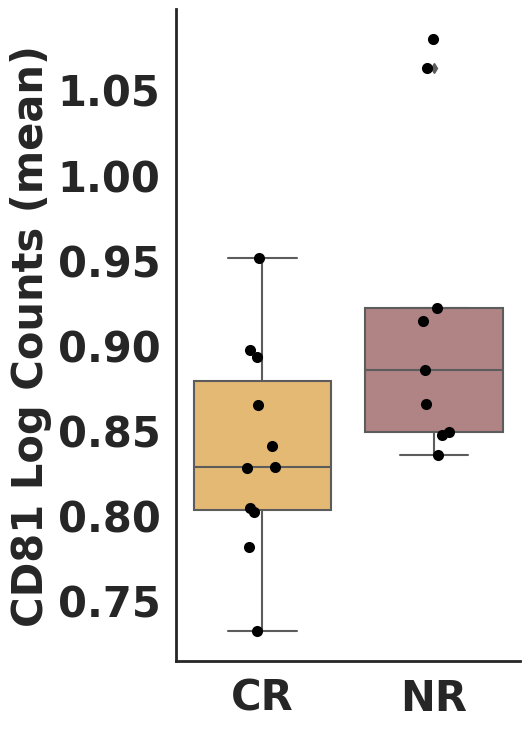

In [26]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

gene = "CD81"

color_palette = ["#F6BD60", "#B77B7E"]

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

print(f'Gene: {gene}')
model_data = []
patients = adata_log_CR_NR.obs['barcode'].unique()

for patient in patients:
    # Proportions using log-transformed data
    patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
    gene_expr_log = patient_data_log[:, gene].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene].X > 0
    proportion = np.sum(gene_expr_log) / patient_data_log.shape[0]

    # Gene counts using combat-corrected data
    patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]
    gene_count = np.mean(patient_data_combat[:, gene].X)

    model_data.append({
        'Patient': patient,
        'Response': patient_data_log.obs['response'].values[0],
        'Proportion_Positive': proportion,
        f'{gene}_Count': gene_count
    })

model_df = pd.DataFrame(model_data)
model_df[f'{gene}_Count'] = model_df[f'{gene}_Count'].astype(float)

# Perform Wilcoxon rank-sum test for each variable between CR and NR
cr_group = model_df[model_df['Response'] == 'CR']
nr_group = model_df[model_df['Response'] == 'NR']
all_tests = []
tests = [
    ('Proportion', cr_group['Proportion_Positive'], nr_group['Proportion_Positive']),
    (f'{gene} Counts', cr_group[f'{gene}_Count'], nr_group[f'{gene}_Count']),
]

for test_name, cr_data, nr_data in tests:
    w_stat, p_val = ranksums(cr_data, nr_data)
    all_tests.append({
        'Gene': gene,
        'Test': test_name,
        'P_value': p_val
    })

results_df = pd.DataFrame(all_tests)
print(f"\nTotal number of tests being corrected for: {len(results_df)}")

# Perform multiple testing corrections
results_df['FDR_BH'] = multipletests(results_df['P_value'], method='fdr_bh')[1]
results_df['Bonferroni'] = multipletests(results_df['P_value'], method='bonferroni')[1]

# Print results
print(f'\nResults for {gene}:')
for _, row in results_df.iterrows():
    print(f"{row['Test']}:")
    print(f"  Raw p-value: {row['P_value']:.4f}")
    print(f"  FDR-corrected p-value: {row['FDR_BH']:.4f}")
    print(f"  Bonferroni-corrected p-value: {row['Bonferroni']:.4f}")

results_df.to_csv('CD81_analysis_results.csv', index=False)

sns.set_style("white")

# 1. Proportion of cells expressing CD81 across response groups
plt.figure(figsize=(6, 8))
sns.boxplot(x='Response', y='Proportion_Positive', data=model_df, palette=color_palette)
sns.stripplot(x='Response', y='Proportion_Positive', data=model_df, color='black', size=8, jitter=True)
plt.xlabel('')  
plt.ylabel('Proportion of CAR T-cell', fontweight='bold')
plt.tick_params(axis='both', which='both', length=8, width=2, labelsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('CD81_proportion.pdf', bbox_inches='tight', dpi=300)
plt.show()

# 2. Gene counts across response groups for CD81
plt.figure(figsize=(6, 8))
sns.boxplot(x='Response', y=f'{gene}_Count', data=model_df, palette=color_palette)
sns.stripplot(x='Response', y=f'{gene}_Count', data=model_df, color='black', size=8, jitter=True)
plt.xlabel('')  
plt.ylabel(f'{gene} Log Counts (mean)', fontweight='bold')
plt.tick_params(axis='both', which='both', length=8, width=2, labelsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('CD81_counts.pdf', bbox_inches='tight', dpi=300)
plt.show()

Processing Gene: FABP5


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


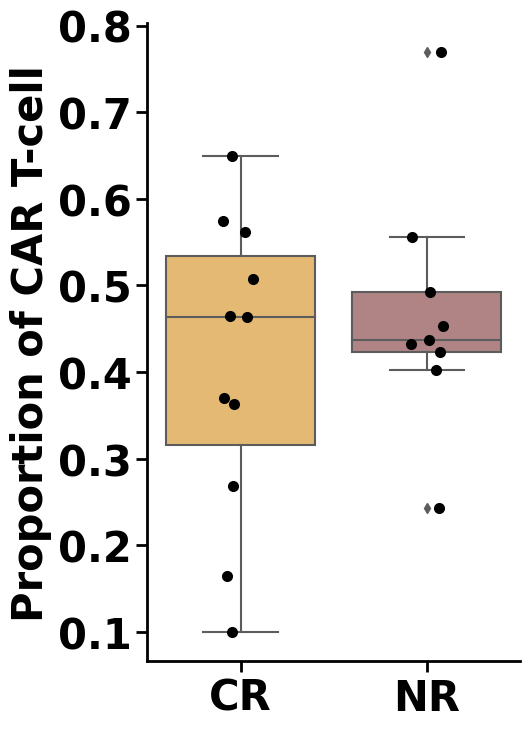

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


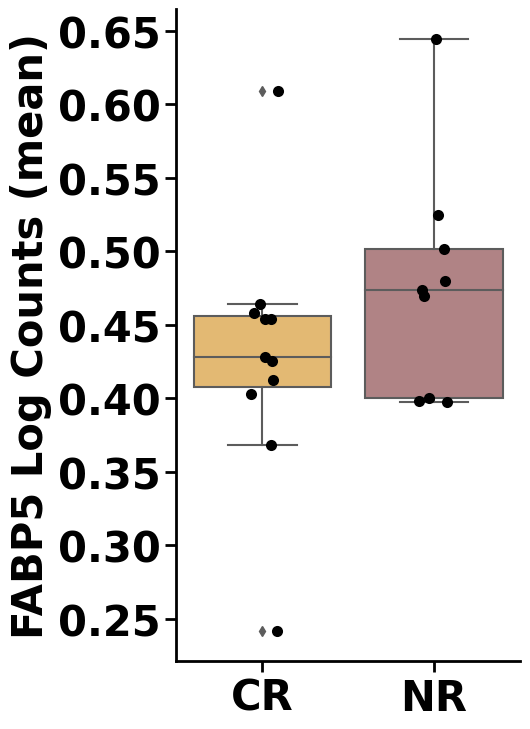

Processing Gene: CD7


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


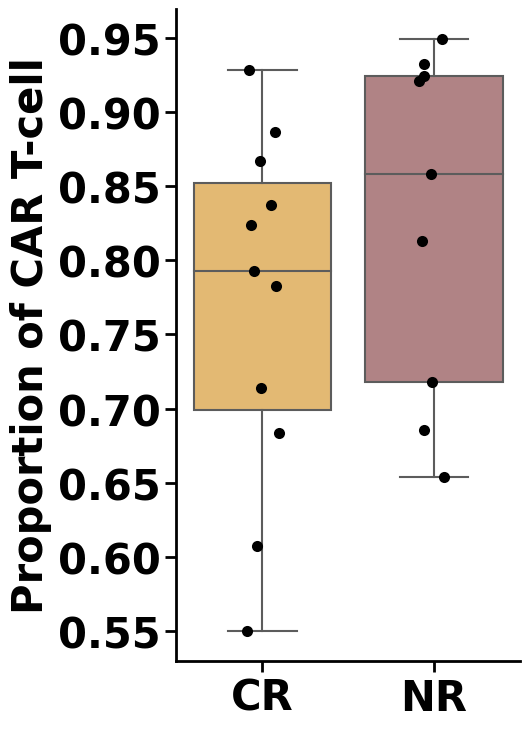

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


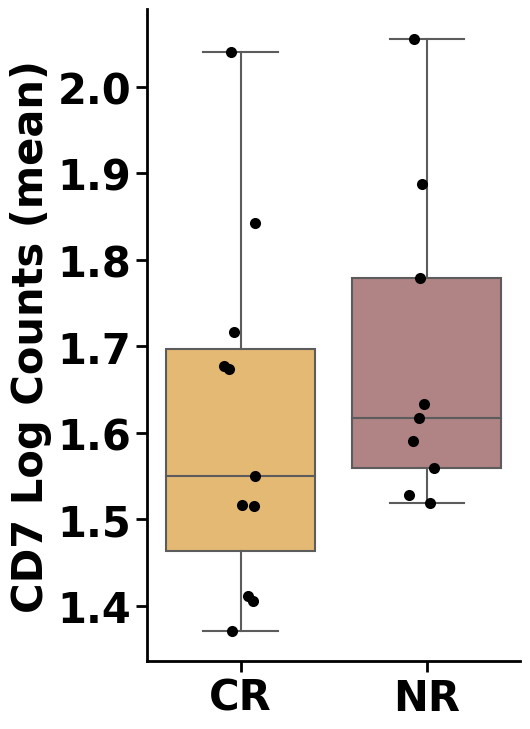

Processing Gene: ENO1


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


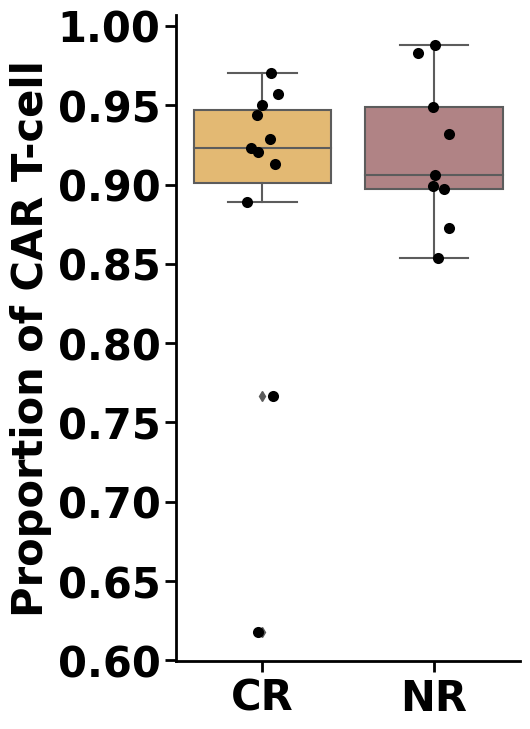

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


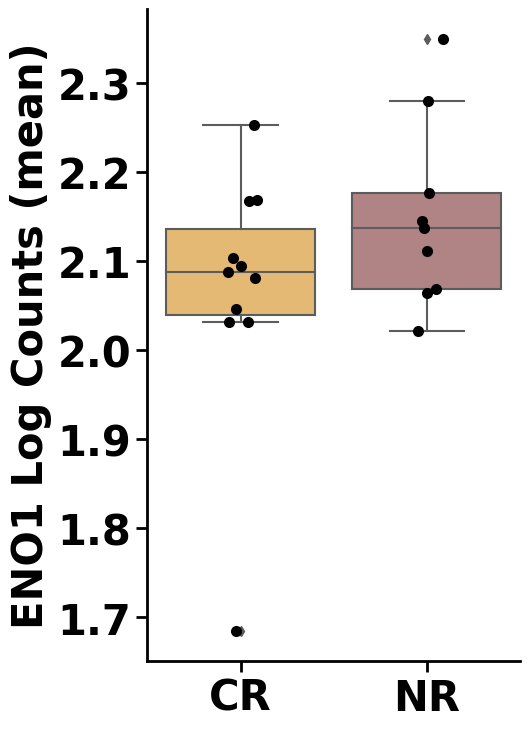


Results for FABP5:
Proportion:
  Raw p-value: 0.7903
  FDR-corrected p-value: 0.9697
  Bonferroni-corrected p-value: 1.0000
Proportion:
  Raw p-value: 0.7903
  FDR-corrected p-value: 0.9697
  Bonferroni-corrected p-value: 1.0000
FABP5 Counts:
  Raw p-value: 0.1837
  FDR-corrected p-value: 0.4871
  Bonferroni-corrected p-value: 1.0000
Proportion:
  Raw p-value: 0.2390
  FDR-corrected p-value: 0.4871
  Bonferroni-corrected p-value: 1.0000
Proportion:
  Raw p-value: 0.2390
  FDR-corrected p-value: 0.4871
  Bonferroni-corrected p-value: 1.0000
CD7 Counts:
  Raw p-value: 0.2706
  FDR-corrected p-value: 0.4871
  Bonferroni-corrected p-value: 1.0000
Proportion:
  Raw p-value: 0.9697
  FDR-corrected p-value: 0.9697
  Bonferroni-corrected p-value: 1.0000
Proportion:
  Raw p-value: 0.9697
  FDR-corrected p-value: 0.9697
  Bonferroni-corrected p-value: 1.0000
ENO1 Counts:
  Raw p-value: 0.2390
  FDR-corrected p-value: 0.4871
  Bonferroni-corrected p-value: 1.0000

Results for CD7:
Proportion:
  

In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

genes = ["FABP5", "CD7", "ENO1"]

color_palette = ["#F6BD60", "#B77B7E"]

all_tests = []
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

for gene in genes:
    print(f'Processing Gene: {gene}')
    model_data = []
    patients = adata_log_CR_NR.obs['barcode'].unique()

    for patient in patients:
        patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
        gene_expr_log = patient_data_log[:, gene].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene].X > 0
        proportion = np.sum(gene_expr_log) / patient_data_log.shape[0]

        patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]
        gene_count = np.mean(patient_data_combat[:, gene].X)

        model_data.append({
            'Patient': patient,
            'Response': patient_data_log.obs['response'].values[0],
            'Proportion_Positive': proportion,
            f'{gene}_Count': gene_count
        })

    model_df = pd.DataFrame(model_data)
    model_df[f'{gene}_Count'] = model_df[f'{gene}_Count'].astype(float)

    # Perform Wilcoxon rank-sum test
    cr_group = model_df[model_df['Response'] == 'CR']
    nr_group = model_df[model_df['Response'] == 'NR']
    w_stat, p_val = ranksums(cr_group['Proportion_Positive'], 
                            nr_group['Proportion_Positive'])
    
    all_tests.append({
        'Gene': gene,
        'Test': 'Proportion',
        'P_value': p_val
    })

    # Perform Wilcoxon rank-sum test for each variable between CR and NR
    cr_group = model_df[model_df['Response'] == 'CR']
    nr_group = model_df[model_df['Response'] == 'NR']

    # Perform all tests and store results
    tests = [
        ('Proportion', cr_group['Proportion_Positive'], nr_group['Proportion_Positive']),
        (f'{gene} Counts', cr_group[f'{gene}_Count'], nr_group[f'{gene}_Count'])
    ]

    for test_name, cr_data, nr_data in tests:
        w_stat, p_val = ranksums(cr_data, nr_data)
        all_tests.append({
            'Gene': gene,
            'Test': test_name,
            'P_value': p_val
        })

    # 1. proportion plot
    plt.figure(figsize=(6, 8))
    sns.boxplot(x='Response', y='Proportion_Positive', data=model_df, palette=color_palette)
    sns.stripplot(x='Response', y='Proportion_Positive', data=model_df, color='black', size=8, jitter=True)
    plt.xlabel('')
    plt.ylabel('Proportion of CAR T-cell', fontweight='bold')
    plt.tick_params(axis='both', which='both', length=8, width=2, labelsize=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()  
    plt.close()  

    # 2. Gene counts across response groups for JUND
    plt.figure(figsize=(6, 8))
    sns.boxplot(x='Response', y=f'{gene}_Count', data=model_df, palette=color_palette)
    sns.stripplot(x='Response', y=f'{gene}_Count', data=model_df, color='black', size=8, jitter=True)
    plt.xlabel('')  
    plt.ylabel(f'{gene} Log Counts (mean)', fontweight='bold')
    plt.tick_params(axis='both', which='both', length=8, width=2, labelsize=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
# Convert all tests to DataFrame and perform multiple testing corrections
results_df = pd.DataFrame(all_tests)
results_df['FDR_BH'] = multipletests(results_df['P_value'], method='fdr_bh')[1]
results_df['Bonferroni'] = multipletests(results_df['P_value'], method='bonferroni')[1]

for gene in genes:
    # Print results
    print(f'\nResults for {gene}:')
    for _, row in results_df.iterrows():
        print(f"{row['Test']}:")
        print(f"  Raw p-value: {row['P_value']:.4f}")
        print(f"  FDR-corrected p-value: {row['FDR_BH']:.4f}")
        print(f"  Bonferroni-corrected p-value: {row['Bonferroni']:.4f}")

results_df.to_csv('gene_expression_analysis_results.csv', index=False)

Evaluating gene: CD81

Averaged feature importances for CD81:
Proportion    0.840453
CD81          0.159547
dtype: float32


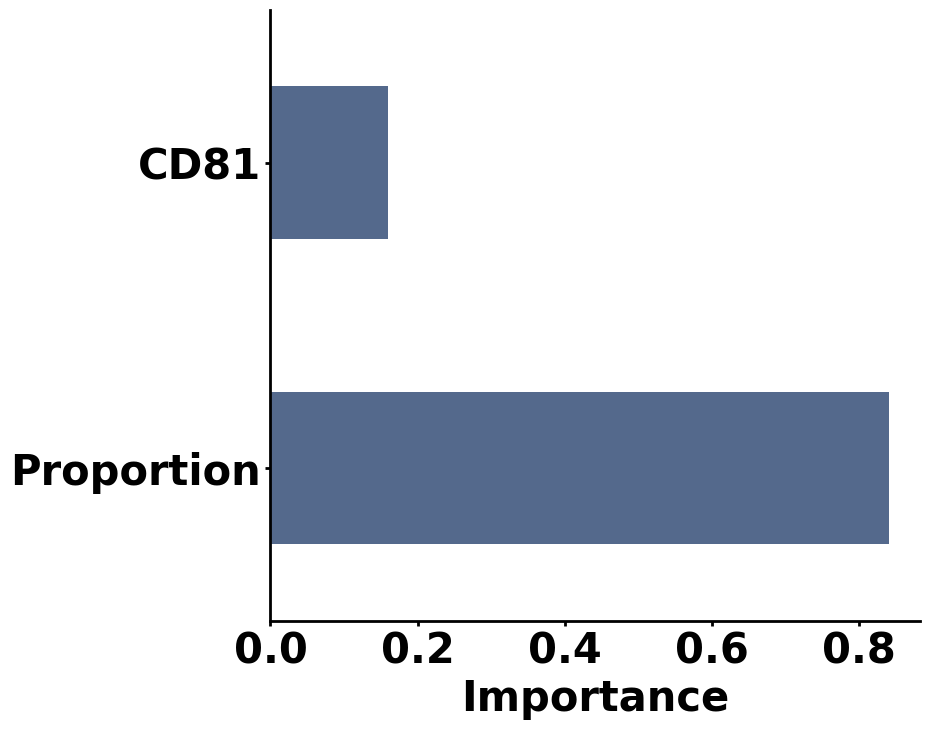

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from scipy.stats import zscore

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

le = LabelEncoder()
adata_log_CR_NR.obs['Response_Encoded'] = le.fit_transform(adata_log_CR_NR.obs['response'])  # CR = 0, NR = 1

genes = ["CD81"]

model_data = []

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for gene in genes:
    print(f"Evaluating gene: {gene}")
    model_data = []
    patients = adata_log_CR_NR.obs['barcode'].unique()

    for patient in patients:
        patient_data = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]

        gene_expr = patient_data[:, gene].X.toarray().flatten() > 0 if issparse(patient_data.X) else patient_data[:, gene].X > 0
        proportion = np.sum(gene_expr) / patient_data.shape[0]
        gene_count = np.mean(patient_data[:, gene].X)

        model_data.append({
            'Patient': patient,
            'Response_Encoded': patient_data.obs['Response_Encoded'].values[0],
            'Proportion': proportion,
            f'{gene}': gene_count
        })

    model_df = pd.DataFrame(model_data)
    model_df[f'{gene}'] = model_df[f'{gene}'].astype(float)

    X = model_df[['Proportion', f'{gene}']]
    y = model_df['Response_Encoded']

    importances_per_fold = []

    # Perform 5-fold cross-validation
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train an XGBoost classifier
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train, y_train)

        # Store feature importance for this fold
        fold_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
        importances_per_fold.append(fold_importances)

    # Average feature importances across folds
    avg_importances = pd.concat(importances_per_fold, axis=1).mean(axis=1).sort_values(ascending=False)

    print(f"\nAveraged feature importances for CD81:")
    print(avg_importances)

    # Visualization of averaged feature importance
    avg_importances.plot(kind='barh', color='#54698C', figsize=(10, 8))
    plt.xlabel('Importance')
    plt.ylabel('')
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


Gene: CD81


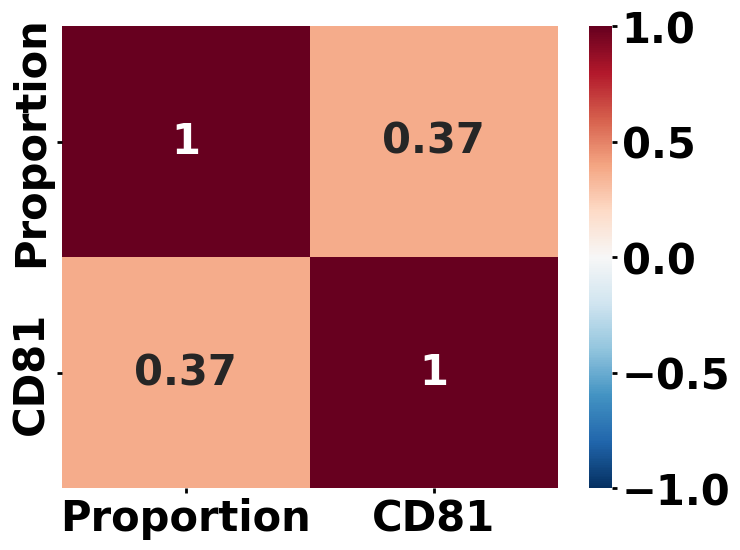

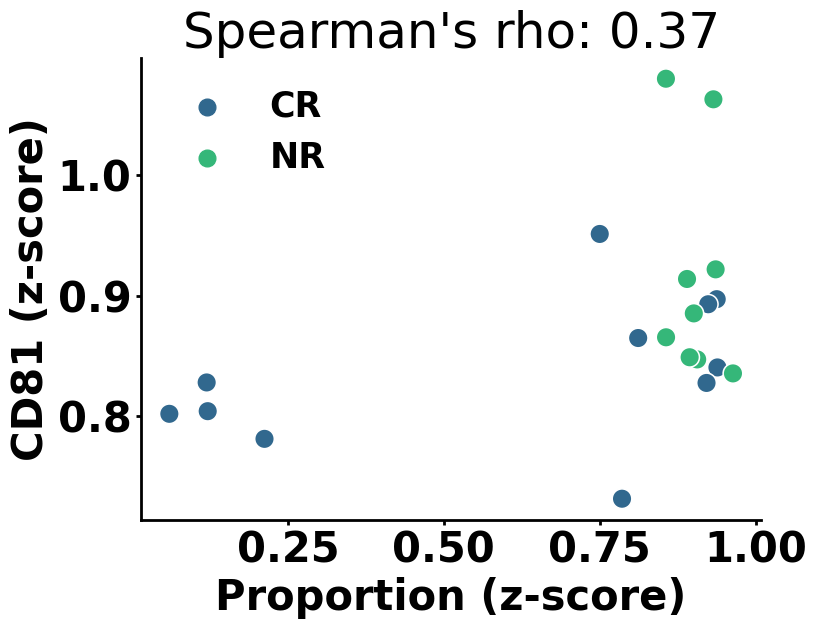

In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')

adata_log_CD8 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_combat_CD8 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD8[(adata_log_CD8.obs['response'] == 'CR') | (adata_log_CD8.obs['response'] == 'NR')].copy()
adata_combat_CR_NR = adata_combat_CD8[(adata_combat_CD8.obs['response'] == 'CR') | (adata_combat_CD8.obs['response'] == 'NR')].copy()

gene_pairs = [
    ("CD81")
]

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

print(f'Gene: {gene}')
model_data = []
patients = adata_log_CR_NR.obs['barcode'].unique()

for patient in patients:
    patient_data_log = adata_log_CR_NR[adata_log_CR_NR.obs['barcode'] == patient]
    gene_expr_log = patient_data_log[:, gene].X.toarray().flatten() > 0 if issparse(patient_data_log.X) else patient_data_log[:, gene].X > 0
    proportion = np.sum(gene_expr_log) / patient_data_log.shape[0]

    patient_data_combat = adata_combat_CR_NR[adata_combat_CR_NR.obs['barcode'] == patient]
    gene_count = np.mean(patient_data_combat[:, gene].X)

    model_data.append({
        'Patient': patient,
        'Response': patient_data_log.obs['response'].values[0],
        'Proportion': proportion,
        f'{gene}': gene_count
    })

model_df = pd.DataFrame(model_data)
model_df[f'{gene}'] = model_df[f'{gene}'].astype(float)

# Heatmap of Spearman Correlation (using z-score normalized data)
correlation_matrix = model_df[['Proportion', f'{gene}']].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.show()

# Scatter plot with Spearman's rho displayed (using z-score normalized data)
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(x=model_df['Proportion'], y=model_df[f'{gene}'], hue=model_df['Response'], palette='viridis', s=200)
plt.legend(frameon=False, loc='best', fontsize='small', scatterpoints=1, markerscale=2)  # `frameon=False` removes the frame, `fontsize='small'` reduces legend size
rho, _ = spearmanr(model_df['Proportion'], model_df[f'{gene}'])
plt.title(f"Spearman's rho: {rho:.2f}")

plt.xlabel('Proportion (z-score)')
plt.ylabel(f'{gene} (z-score)')
sns.despine(top=True, right=True)
plt.show()




Analyzing CTLA4...


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


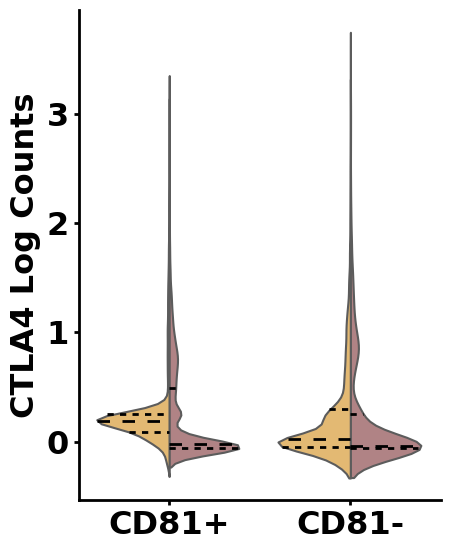

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


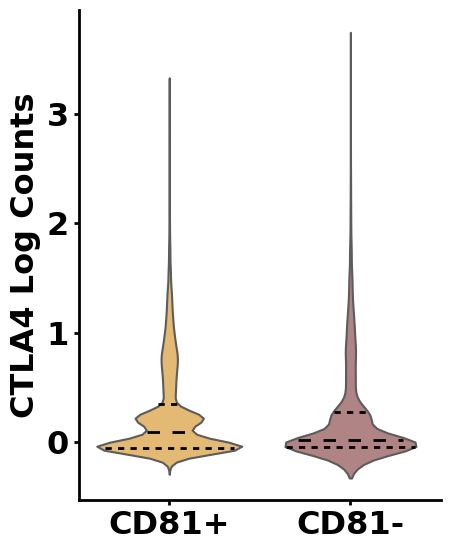


Analyzing LAG3...


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


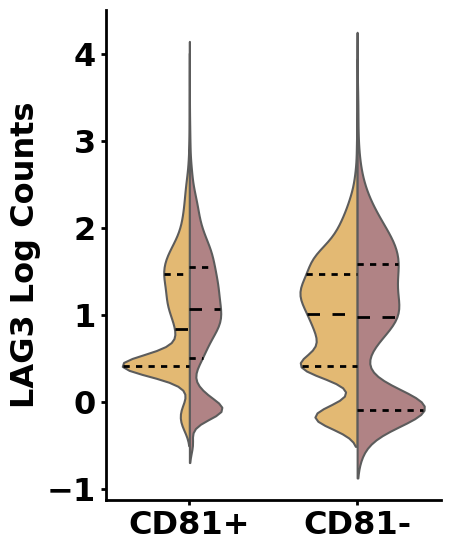

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


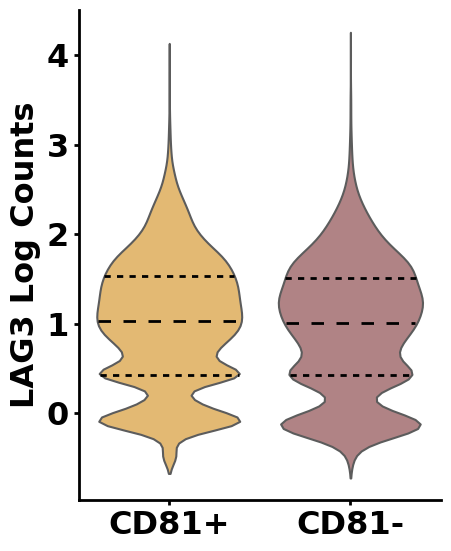


Analyzing PDCD1...


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


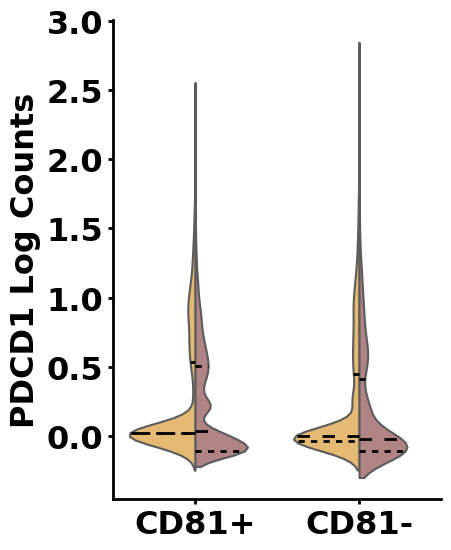

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


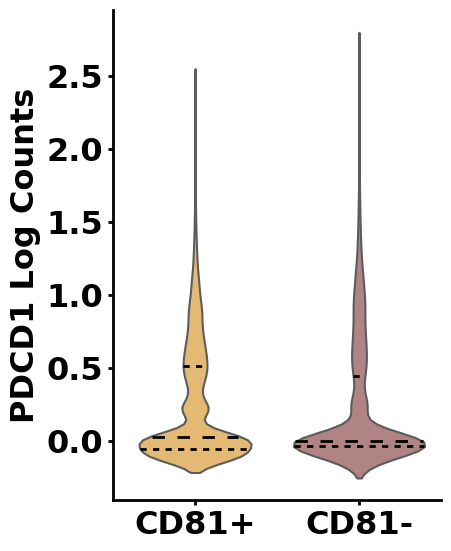


Analyzing HAVCR2...


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


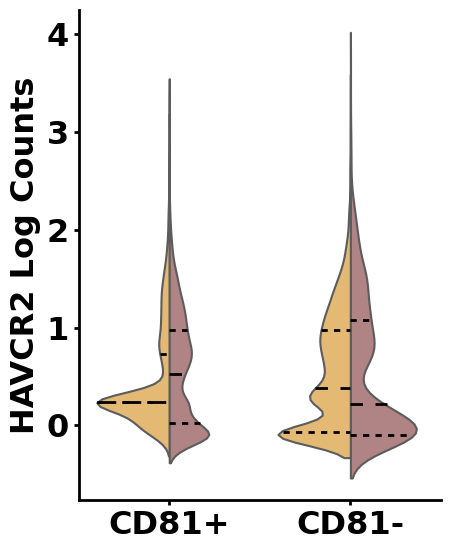

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


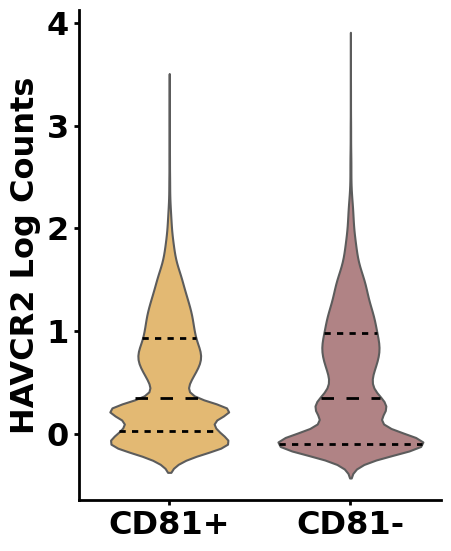


Analyzing TIGIT...


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


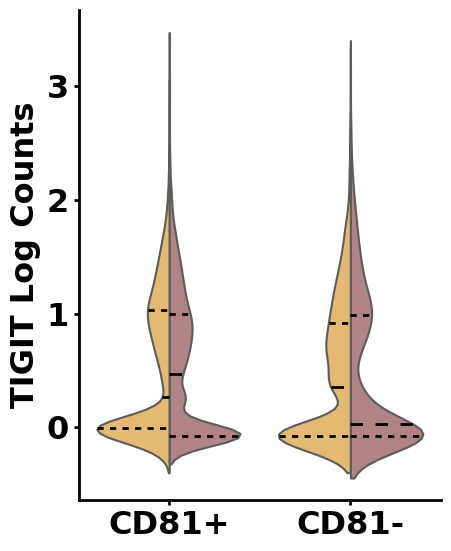

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


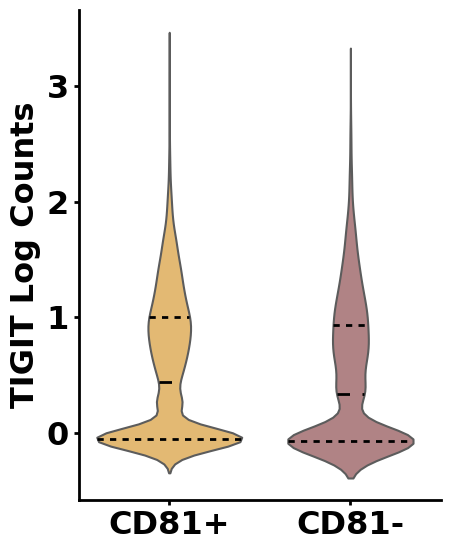


Analyzing TBX21...


/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


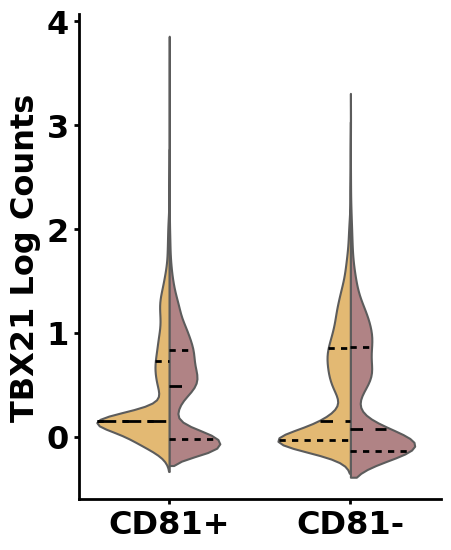

/home/emma/miniconda3/envs/serverGPU/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


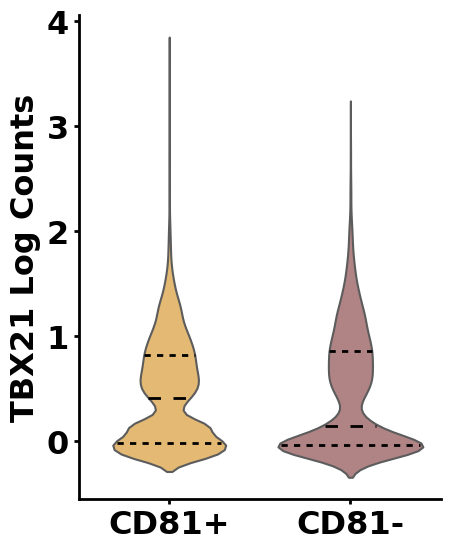


Statistical Analysis Results:
------------------------------------------------------------------------------------------------------------------------
Gene       Comparison      Raw p-value     FDR q-value     Bonferroni p-value   Statistic  Sample Sizes        
------------------------------------------------------------------------------------------------------------------------
CTLA4      Overall         2.14e-06 2.76e-06 3.86e-05 4.739 (n+=20657, n-=6927)
CTLA4      CR only         4.37e-149 7.87e-148 7.87e-148 26.005 (n+=5278, n-=5336)
CTLA4      NR only         1.57e-10 3.54e-10 2.83e-09 6.398 (n+=15379, n-=1591)
LAG3       Overall         3.26e-09 5.87e-09 5.87e-08 5.918 (n+=20657, n-=6927)
LAG3       CR only         2.38e-02 2.52e-02 4.29e-01 -2.260 (n+=5278, n-=5336)
LAG3       NR only         1.28e-07 1.92e-07 2.30e-06 5.282 (n+=15379, n-=1591)
PDCD1      Overall         4.31e-07 5.97e-07 7.76e-06 5.055 (n+=20657, n-=6927)
PDCD1      CR only         5.87e-104 5.28e-103 1.06e

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ranksums
from scipy.sparse import issparse
from statsmodels.stats.multitest import multipletests

adata_log = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_log.h5ad')
adata_log_CD4 = adata_log[adata_log.obs['cell_type'] == 'CD8'].copy()
adata_log_CR_NR = adata_log_CD4[adata_log_CD4.obs['response'].isin(['CR', 'NR'])].copy()

adata_combat = sc.read_h5ad('/home/emma/data/CART/Harvard_Stanford_infusion_D7sorted_CD3E_CD4_CD8A_highly_variable_combat.h5ad')
adata_combat_CD4 = adata_combat[adata_combat.obs['cell_type'] == 'CD8'].copy()
adata_combat_CR_NR = adata_combat_CD4[adata_combat_CD4.obs['response'].isin(['CR', 'NR'])].copy()

primary_gene = "CD81"
CD81_log = adata_log_CR_NR[:, primary_gene].X.toarray().flatten() if issparse(adata_log_CR_NR.X) else adata_log_CR_NR[:, primary_gene].X.flatten()
mask_CD81_positive = CD81_log > 0

population_label = f'{primary_gene}_positive'
adata_combat_CR_NR.obs[population_label] = np.where(mask_CD81_positive, 'CD81+', 'CD81-')
adata_combat_CR_NR.obs[population_label] = adata_combat_CR_NR.obs[population_label].astype('category')

genes = [
    "CTLA4",  # CD152 (CTLA4)
    "LAG3",   # CD223 (LAG3)
    "PDCD1",  # CD279 (PD1)
    "HAVCR2", # CD366 (TIM3)
    "TIGIT",  # TIGIT
    "TBX21",  # T-bet
]

def create_violin_plots(data, x, y, gene_name):
    """Create both split and non-split violin plots with the specified styling."""
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['font.size'] = 23
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['ytick.major.width'] = 2

    # Plot with hue (split by response)
    plt.figure(figsize=(5, 6))
    ax = sns.violinplot(
        data=data,
        x=x,
        y=y,
        hue='response',
        split=True,
        inner="quart",
        palette=["#F6BD60", "#B77B7E"],
        order=['CD81+', 'CD81-']
    )
    sns.despine()

    for line in ax.lines:
        line.set_linewidth(2)
        line.set_color('black')

    plt.legend([], [], frameon=False)
    plt.title('')
    plt.xlabel('')
    plt.ylabel(f'{gene_name} Log Counts')
    plt.tight_layout()
    plt.savefig(f'{gene_name}_split_violin.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Plot without hue (non-split)
    plt.figure(figsize=(5, 6))
    ax = sns.violinplot(
        data=data,
        x=x,
        y=y,
        inner="quart",
        palette=["#F6BD60", "#B77B7E"],
        order=['CD81+', 'CD81-']
    )
    sns.despine()

    for line in ax.lines:
        line.set_linewidth(2)
        line.set_color('black')

    plt.legend([], [], frameon=False)
    plt.title('')
    plt.xlabel('')
    plt.ylabel(f'{gene_name} Log Counts')
    plt.tight_layout()
    plt.savefig(f'{gene_name}_violin.png', bbox_inches='tight', dpi=300)
    plt.show()

results = []
df = adata_combat_CR_NR.to_df()
df[population_label] = adata_combat_CR_NR.obs[population_label].values
df['response'] = adata_combat_CR_NR.obs['response'].values

for gene in genes:
    if gene in adata_combat_CR_NR.var_names:
        print(f"\nAnalyzing {gene}...")
        
        df['Expression'] = adata_combat_CR_NR[:, gene].X.toarray().flatten()
        create_violin_plots(
            data=df,
            x=population_label,
            y='Expression',
            gene_name=gene
        )
        
        # Statistical tests
        # 1. Overall comparison
        positive_cells = df[df[population_label] == 'CD81+']['Expression']
        negative_cells = df[df[population_label] == 'CD81-']['Expression']
        stat, p_value = ranksums(positive_cells, negative_cells)
        results.append({
            'gene': gene,
            'comparison': 'Overall',
            'statistic': stat,
            'p_value': p_value,
            'n_positive': len(positive_cells),
            'n_negative': len(negative_cells)
        })
        
        # 2. CR only comparison
        cr_positive = df[(df[population_label] == 'CD81+') & (df['response'] == 'CR')]['Expression']
        cr_negative = df[(df[population_label] == 'CD81-') & (df['response'] == 'CR')]['Expression']
        if len(cr_positive) > 0 and len(cr_negative) > 0:
            stat, p_value = ranksums(cr_positive, cr_negative)
            results.append({
                'gene': gene,
                'comparison': 'CR only',
                'statistic': stat,
                'p_value': p_value,
                'n_positive': len(cr_positive),
                'n_negative': len(cr_negative)
            })
        
        # 3. NR only comparison
        nr_positive = df[(df[population_label] == 'CD81+') & (df['response'] == 'NR')]['Expression']
        nr_negative = df[(df[population_label] == 'CD81-') & (df['response'] == 'NR')]['Expression']
        if len(nr_positive) > 0 and len(nr_negative) > 0:
            stat, p_value = ranksums(nr_positive, nr_negative)
            results.append({
                'gene': gene,
                'comparison': 'NR only',
                'statistic': stat,
                'p_value': p_value,
                'n_positive': len(nr_positive),
                'n_negative': len(nr_negative)
            })

results_df = pd.DataFrame(results)
p_values = results_df['p_value'].values
results_df['FDR_q_value'] = multipletests(p_values, method='fdr_bh')[1]
results_df['Bonferroni_p_value'] = multipletests(p_values, method='bonferroni')[1]
results_df.to_csv('gene_expression_analysis_results.csv', index=False)

print("\nStatistical Analysis Results:")
print("-" * 120)
print(f"{'Gene':<10} {'Comparison':<15} {'Raw p-value':<15} {'FDR q-value':<15} "
      f"{'Bonferroni p-value':<20} {'Statistic':<10} {'Sample Sizes':<20}")
print("-" * 120)

for _, row in results_df.iterrows():
    print(f"{row['gene']:<10} {row['comparison']:<15} {row['p_value']:.2e} {row['FDR_q_value']:.2e} "
          f"{row['Bonferroni_p_value']:.2e} {row['statistic']:.3f} "
          f"(n+={row['n_positive']}, n-={row['n_negative']})")

print("\nResults have been saved to 'gene_expression_analysis_results.csv'")
print("Plots have been saved as PNG files for each gene")